In [1]:
!pip install yahoo_fin
!pip install pmdarima

In [2]:
import numpy as np
import matplotlib.pylab as plt

import pandas as pd

import yahoo_fin.stock_info as si
from yahoo_fin import options
from yahoo_fin.stock_info import get_data, tickers_sp500, tickers_nasdaq, tickers_other, get_quote_table

from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import statsmodels.api as sm
import statsmodels

import scipy.stats as stats

from datetime import datetime
from dateutil.relativedelta import relativedelta

import random

import seaborn as sns

from statsmodels.tsa.stattools import adfuller 
from matplotlib.pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose 

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # Remove the CWD from sys.path while we load stuff.


## Datasets

,open,high,low,close,adjclose,volume,ticker
2021-12-07,4631.970215,4694.040039,4631.970215,4686.750000,4686.750000,3334320000,^GSPC
2021-12-08,4690.859863,4705.060059,4674.520020,4701.209961,4701.209961,3061550000,^GSPC
2021-12-09,4691.000000,4695.259766,4665.979980,4667.450195,4667.450195,2851660000,^GSPC
2021-12-10,4687.640137,4713.569824,4670.240234,4712.020020,4712.020020,2858310000,^GSPC
2021-12-13,4710.299805,4710.299805,4667.600098,4668.970215,4668.970215,3322050000,^GSPC
2021-12-14,4642.990234,4660.470215,4606.520020,4634.089844,4634.089844,2454381000,^GSPC


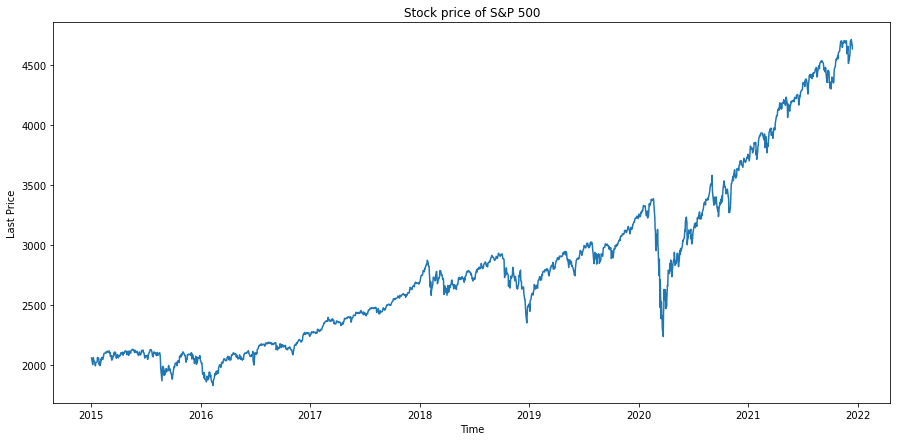

,open,high,low,close,adjclose,volume,ticker
2021-12-07,15510.910156,15720.089844,15507.660156,15686.919922,15686.919922,5091220000,^IXIC
2021-12-08,15690.650391,15792.639648,15618.879883,15786.990234,15786.990234,4600800000,^IXIC
2021-12-09,15720.540039,15796.049805,15511.120117,15517.370117,15517.370117,4484230000,^IXIC
2021-12-10,15629.589844,15677.599609,15477.849609,15630.599609,15630.599609,4395460000,^IXIC
2021-12-13,15621.269531,15637.059570,15408.250000,15413.280273,15413.280273,4549170000,^IXIC
2021-12-14,15215.958008,15317.551758,15097.350586,15237.639648,15237.639648,4224735000,^IXIC


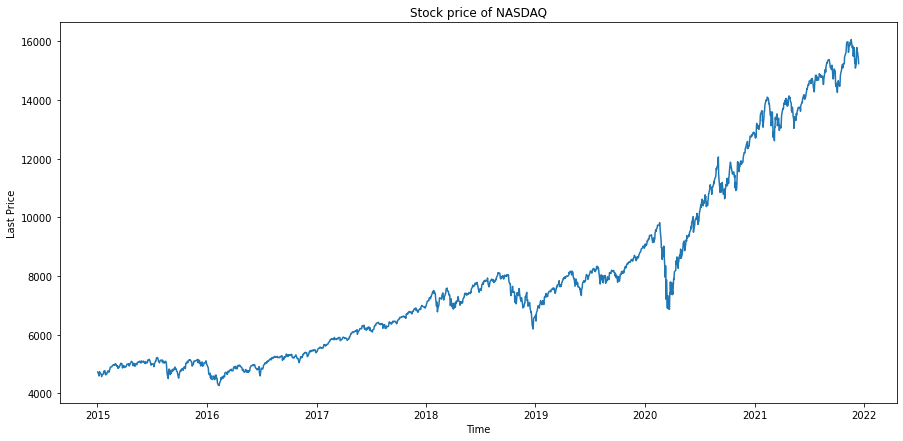

In [3]:
ticker = "^GSPC" #s&p 500

histData = si.get_data(ticker, start_date="01-01-2015")

display(histData.tail(6))

plt.figure(figsize=(15, 7))
plt.plot(histData["close"])

plt.title("Stock price of S&P 500")
plt.xlabel("Time")
plt.ylabel("Last Price")

plt.show()

ticker2 = "^IXIC"
histData2 = si.get_data(ticker2, start_date="01-01-2015")

display(histData2.tail(6))


plt.figure(figsize=(15, 7))
plt.plot(histData2["close"])

plt.title("Stock price of NASDAQ")
plt.xlabel("Time")
plt.ylabel("Last Price")

plt.show()

df_sp = pd.DataFrame(histData.close)
df_na = pd.DataFrame(histData2.close)

## Testing Stationary

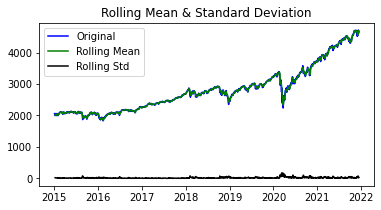

Results of Dickey-Fuller Test:
Test Statistic                    0.636138
p-value                           0.988473
#Lags Used                        9.000000
Number of Observations Used    1741.000000
Critical Value (1%)              -3.434112
Critical Value (5%)              -2.863202
Critical Value (10%)             -2.567655
dtype: float64
result : time series is not stationary


In [4]:
# Checking Stasionarity - Dicky Fuller Test

def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(4).mean() # around 4 weeks on each month
    rolstd = timeseries.rolling(4).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='green', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
        
    print(dfoutput)
    
    if dfoutput['p-value'] < 0.05:
        print('result : time series is stationary')
    else : print('result : time series is not stationary')

plt.rcParams.update({'figure.figsize':(6,3)})
test_stationarity(df_sp)

## Finding Parameters

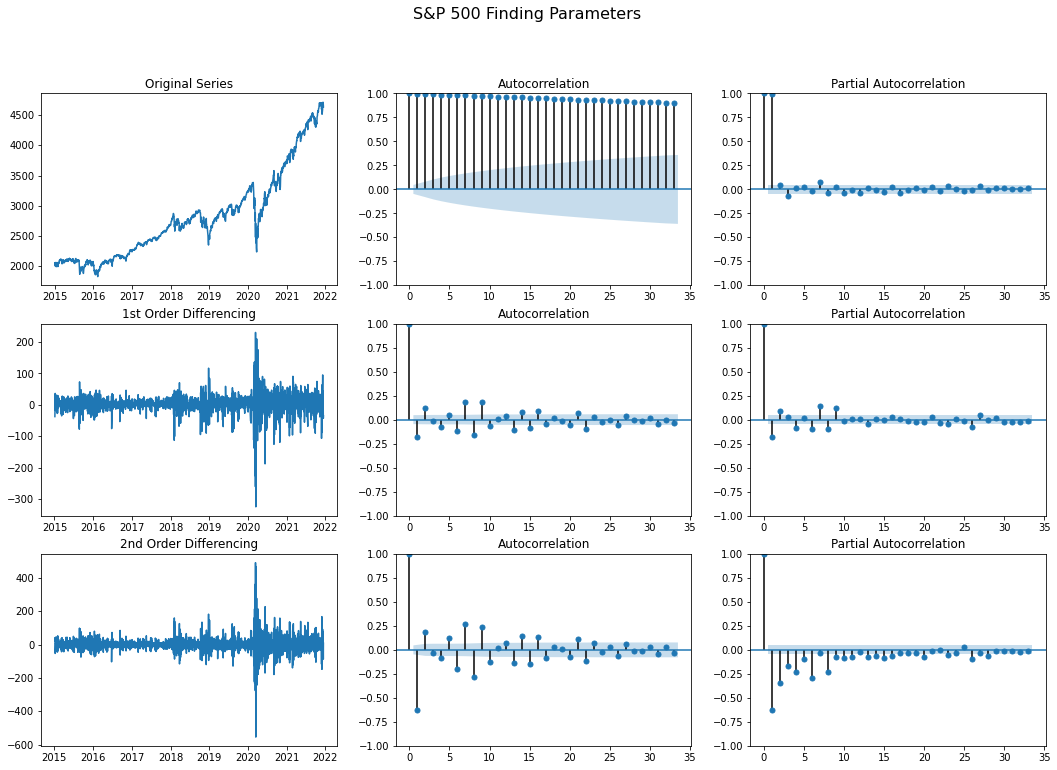

In [5]:
plt.rcParams.update({'figure.figsize':(18,12)})
fig, ax = plt.subplots(nrows=3, ncols=3)
ax[0,0].plot(df_sp['close']);
ax[0,0].set_title('Original Series');
plot_acf(df_sp['close'], ax=ax[0,1]);
plot_pacf(df_sp['close'], ax = ax[0,2]);


#fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax[1,0].plot(df_sp['close'].diff());
ax[1,0].set_title('1st Order Differencing');
plot_acf(df_sp['close'].diff().dropna(), ax=ax[1,1]);
plot_pacf(df_sp['close'].diff().dropna(), ax = ax[1,2]);

# 2nd Differencing

ax[2,0].plot(df_sp['close'].diff().diff());
ax[2,0].set_title('2nd Order Differencing');
plot_acf(df_sp['close'].diff().diff().dropna(), ax=ax[2,1]);
plot_pacf(df_sp['close'].diff().diff().dropna(), ax = ax[2,2]);

plt.suptitle("S&P 500 Finding Parameters", fontsize = 16)
plt.show()

## ARIMA Auto Model

#### S&P 500

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16991.015, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17055.918, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16997.848, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17008.519, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17057.712, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16986.294, Time=0.84 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16984.836, Time=0.50 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16985.292, Time=0.74 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16933.675, Time=4.61 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16901.590, Time=6.44 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16982.146, Time=4.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=16979.220, Time=8.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16980.113, Time=7.64 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=16904.405, Time=1.18 sec

Best model:  ARIMA

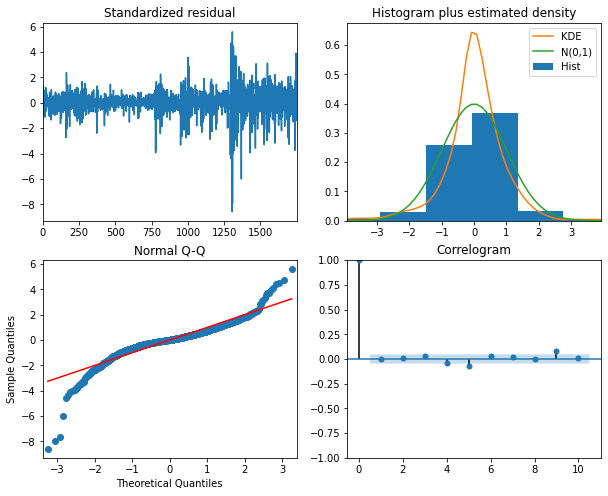

In [6]:
arima_model_sp = pm.auto_arima(df_sp, start_p=1, start_q=1, test = "adf",
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(arima_model_sp.summary())
arima_model_sp.plot_diagnostics(figsize=(10, 8))
plt.show()

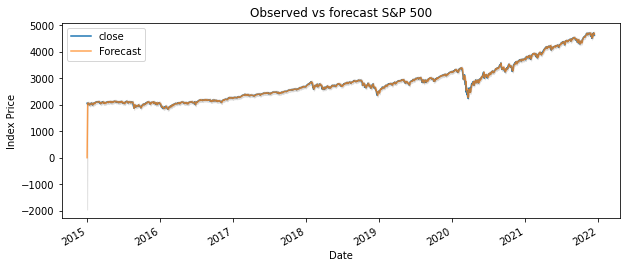

In [7]:
plt.rcParams.update({'figure.figsize':(10,4)})
model = statsmodels.tsa.arima.model.ARIMA(df_sp, order = (3,1,2))
results = model.fit()

pred = results.get_prediction(start=pd.to_datetime('2015-01-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_sp.plot()
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='grey', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Index Price')
ax.set_title('Observed vs forecast S&P 500')
plt.legend()

plt.show()

#### NASDAQ

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21366.027, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21410.057, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21369.356, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21375.073, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21413.302, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21365.560, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21363.685, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=21365.301, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=21349.586, Time=3.02 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=21316.162, Time=3.69 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21366.275, Time=2.02 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=21351.456, Time=5.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=21357.339, Time=4.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=21320.597, Time=1.69 sec

Best model:  ARIMA

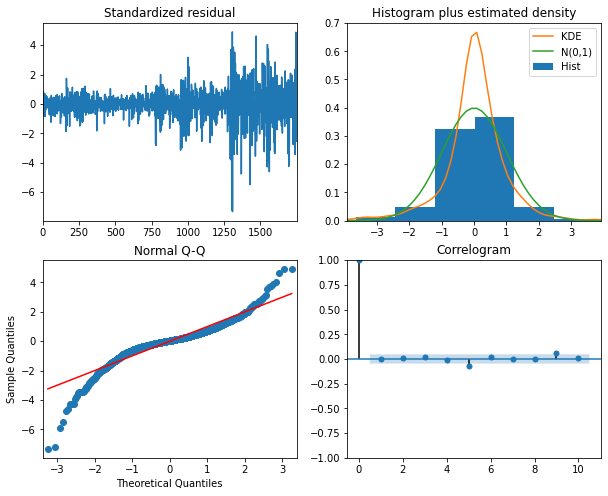

In [8]:
arima_model_na = pm.auto_arima(df_na, start_p=1, start_q=1, test = "adf",
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(arima_model_na.summary())
arima_model_na.plot_diagnostics(figsize=(10, 8))
plt.show()

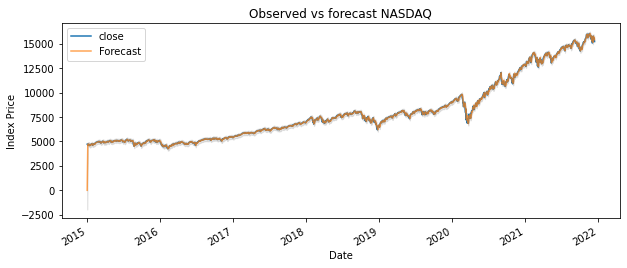

In [9]:
plt.rcParams.update({'figure.figsize':(10,4)})
model = statsmodels.tsa.arima.model.ARIMA(df_na, order = (3,1,2))
results = model.fit()

pred = results.get_prediction(start=pd.to_datetime('2015-01-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_na.plot()
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='grey', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Index Price')
ax.set_title('Observed vs forecast NASDAQ')
plt.legend()

plt.show()

## ARIMA MODEL

In [10]:
np.random.seed(1234)

#### Helper Functions

In [11]:
def helper_ari (n, dataset, startstring, endstring, p, d, q):
  accuracy_list = []

  startdate = datetime.strptime(startstring, '%Y-%m-%d')
  enddate = datetime.strptime(endstring, '%Y-%m-%d')
  r = (enddate + relativedelta(days=1)-startdate).days
  datelist = [(startdate+relativedelta(days=i)).strftime('%Y-%m-%d') for i in range(r)]

  datelist = np.random.choice(datelist, 100)

  for item in datelist:
    today = datetime.strptime(item, '%Y-%m-%d')
    future_date = today + relativedelta(years = n)
    future_date_after = future_date + relativedelta(days = 1)
    future_date = future_date.strftime('%Y-%m-%d')
    future_date_after = future_date_after.strftime('%Y-%m-%d')

    
    train = dataset[today:future_date]
    test = dataset[future_date_after:].head(90)

    try:
      model = statsmodels.tsa.arima.model.ARIMA(train, order=(p, d, q))  

      results = model.fit()
    except:
      continue

    # Forecast
    future_forecast = results.forecast(90)
    # This returns an array of predictions
    fc_series = pd.DataFrame(future_forecast)
    fc_series.index = test.index
    fc_series.columns = ['close']

    test_trend = [0]
    temp = list(test.close)

    for i in range(1, len(test)) :
      if temp[i] >= temp[i-1] :
        test_trend.append(1)
      else:
        test_trend.append(-1)


    # now we deal with the begining element
    if temp[0] >= list(train.close)[-1] :
      test_trend[0] = 1
    else:
      test_trend[0] = -1


    #now forcast
    forecast_trend = [0]
    temp = list(fc_series["close"])

    for i in range(1, len(test)) :
      if temp[i] >= temp[i-1] :
        forecast_trend.append(1)
      else:
        forecast_trend.append(-1)

    # now we deal with the begining element
    if temp[0] >= list(train.close)[-1] :
      forecast_trend[0] = 1
    else:
      forecast_trend[0] = -1


    result = test
    result["test_trend"] = test_trend
    result["forecast"] = fc_series["close"]
    result["forecast_trend"] = forecast_trend
    accuracy = sum(result.test_trend == result.forecast_trend) / len(test)
    accuracy_list.append(accuracy)

  return accuracy_list

In [54]:
def print_results (name, data1, data2, data3, data4, data5):
  print(name, ", 1 year: ", sum(data1)/len(data1), " length: ", len(data1))
  print(name, ", 2 year2: ", sum(data2)/len(data2), " length: ", len(data2))
  print(name, ", 3 year2: ", sum(data3)/len(data3), " length: ", len(data3))
  print(name, ", 4 year2: ", sum(data4)/len(data4), " length: ", len(data4))
  print(name, ", 5 year2: ", sum(data5)/len(data5), " length: ", len(data5))

  fvalue, pvalue = stats.f_oneway(data1,data2,data3,data4,data5)
  print(name, " f value:", fvalue, " p-value: ", pvalue)

  plt.rcParams.update({'figure.figsize':(12,2)})
  fig, ax = plt.subplots(nrows=1, ncols=5)
  ax[0].hist(data1)
  ax[0].set_title(name + ' 1 year')
  ax[1].hist(data2)
  ax[1].set_title(name + ' 2 year')
  ax[2].hist(data3)
  ax[2].set_title(name + ' 3 year')
  ax[3].hist(data4)
  ax[3].set_title(name + ' 4 year')
  ax[4].hist(data5)
  ax[4].set_title(name + ' 5 year')

  

def print_results_2 (name, data1, data2, data3, data4, data5):
  temp = []
  temp = data1 + data2 + data3 + data4 + data5
  df_temp = pd.DataFrame({"year" : ['1 year'] * len(data1) + ['2 years'] * len(data2) + ['3 years'] * len(data3) + ['4 years'] * len(data4) + ['5 years'] * len(data5),
                                   "accuracy" : temp})
  plt.rcParams.update({'figure.figsize':(12,4)})
  sns.set_theme(style="whitegrid")
  ax2 = sns.boxplot(x=df_temp["year"], y = df_temp['accuracy'])
  ax2.set_title(name + " Boxplot of 90 day prediction accuracy based on different years of training data")

#### ARIMA 312

In [13]:
sp_1_arima_updated = helper_ari(1, df_sp, "2015-01-01", "2020-06-01", 3, 1 ,2)
sp_2_arima_updated = helper_ari(2, df_sp, "2015-01-01", "2019-06-01", 3, 1 ,2)
sp_3_arima_updated = helper_ari(3, df_sp, "2015-01-01", "2018-06-01", 3, 1 ,2)
sp_4_arima_updated = helper_ari(4, df_sp, "2015-01-01", "2017-06-01", 3, 1 ,2)
sp_5_arima_updated = helper_ari(5, df_sp, "2015-01-01", "2016-06-01", 3, 1 ,2)

S&P 500 , 1 year:  0.5064444444444444  length:  100
S&P 500 , 2 year2:  0.5077777777777777  length:  100
S&P 500 , 3 year2:  0.48977777777777753  length:  100
S&P 500 , 4 year2:  0.4882222222222222  length:  100
S&P 500 , 5 year2:  0.5039999999999997  length:  100
S&P 500  f value: 2.6146076247871095  p-value:  0.034630826310048025


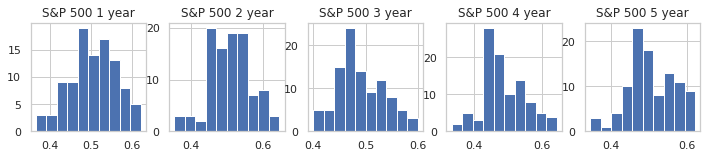

In [55]:
print_results("S&P 500", sp_1_arima_updated, sp_2_arima_updated, sp_3_arima_updated, sp_4_arima_updated, sp_5_arima_updated)


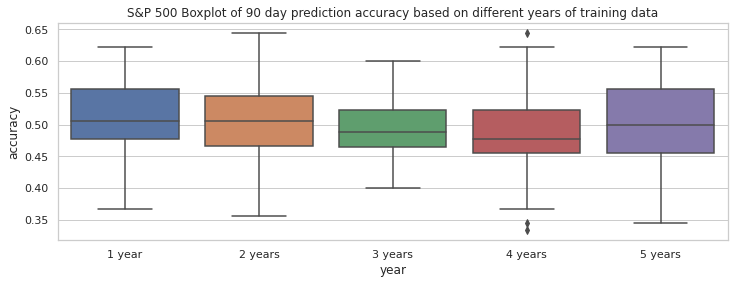

In [15]:
print_results_2("S&P 500", sp_1_arima_updated, sp_2_arima_updated, sp_3_arima_updated, sp_4_arima_updated, sp_5_arima_updated)

In [16]:
na_1_arima_updated = helper_ari(1, df_na, "2015-01-01", "2020-06-01", 3, 1, 2)
na_2_arima_updated = helper_ari(2, df_na, "2015-01-01", "2019-06-01", 3, 1, 2)
na_3_arima_updated = helper_ari(3, df_na, "2015-01-01", "2018-06-01", 3, 1, 2)
na_4_arima_updated = helper_ari(4, df_na, "2015-01-01", "2017-06-01", 3, 1, 2)
na_5_arima_updated = helper_ari(5, df_na, "2015-01-01", "2016-06-01", 3, 1, 2)

NASDAQ , 1 year:  0.5101111111111108  length:  100
NASDAQ , 2 year2:  0.5009999999999998  length:  100
NASDAQ , 3 year2:  0.49533333333333324  length:  100
NASDAQ , 4 year2:  0.4892222222222221  length:  100
NASDAQ , 5 year2:  0.5032222222222219  length:  100
NASDAQ  f value: 2.2463002396952474  p-value:  0.06306429010073533


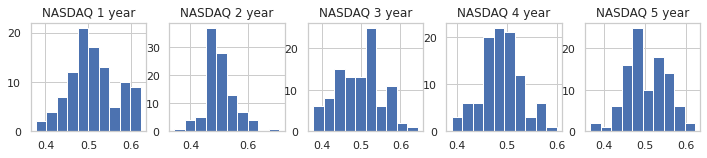

In [56]:
print_results("NASDAQ", na_1_arima_updated, na_2_arima_updated, na_3_arima_updated, na_4_arima_updated, na_5_arima_updated)

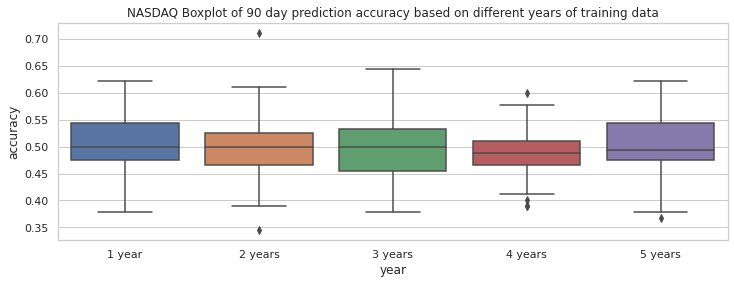

In [18]:
print_results_2("NASDAQ", na_1_arima_updated, na_2_arima_updated, na_3_arima_updated, na_4_arima_updated, na_5_arima_updated)

#### ARIMA 313

In [19]:
sp_1_arima_313 = helper_ari(1, df_sp, "2015-01-01", "2020-06-01", 3, 1 ,3)
sp_2_arima_313 = helper_ari(2, df_sp, "2015-01-01", "2019-06-01", 3, 1 ,3)
sp_3_arima_313 = helper_ari(3, df_sp, "2015-01-01", "2018-06-01", 3, 1 ,3)
sp_4_arima_313 = helper_ari(4, df_sp, "2015-01-01", "2017-06-01", 3, 1 ,3)
sp_5_arima_313 = helper_ari(5, df_sp, "2015-01-01", "2016-06-01", 3, 1 ,3)

S&P 500 , 1 year:  0.5146666666666667  length:  100
S&P 500 , 2 year2:  0.5104444444444447  length:  100
S&P 500 , 3 year2:  0.4969999999999999  length:  100
S&P 500 , 4 year2:  0.5053333333333333  length:  100
S&P 500 , 5 year2:  0.517888888888889  length:  100
S&P 500  f value: 2.4783329039472455  p-value:  0.04329808179998561


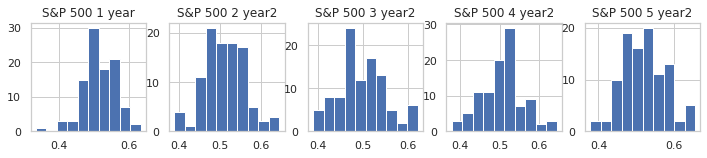

In [20]:
print_results("S&P 500", sp_1_arima_313, sp_2_arima_313, sp_3_arima_313, sp_4_arima_313, sp_5_arima_313)

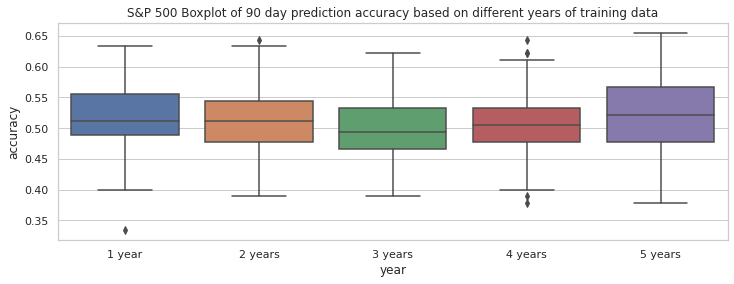

In [21]:
print_results_2("S&P 500", sp_1_arima_313, sp_2_arima_313, sp_3_arima_313, sp_4_arima_313, sp_5_arima_313)

In [22]:
# anova
print(stats.f_oneway(sp_1_arima_313, sp_1_arima_updated))
print(stats.f_oneway(sp_2_arima_313, sp_2_arima_updated))
print(stats.f_oneway(sp_3_arima_313, sp_3_arima_updated))
print(stats.f_oneway(sp_4_arima_313, sp_4_arima_updated))
print(stats.f_oneway(sp_5_arima_313, sp_5_arima_updated))

F_onewayResult(statistic=1.227602510801336, pvalue=0.26921789571408367)
F_onewayResult(statistic=0.11565232910940579, pvalue=0.7341590827314604)
F_onewayResult(statistic=1.1174650754594506, pvalue=0.2917529733540044)
F_onewayResult(statistic=4.276188394710959, pvalue=0.039949796608052174)
F_onewayResult(statistic=2.533854341562337, pvalue=0.11302297667961585)


In [23]:
na_1_arima_313 = helper_ari(1, df_na, "2015-01-01", "2020-06-01", 3, 1 ,3)
na_2_arima_313 = helper_ari(2, df_na, "2015-01-01", "2019-06-01", 3, 1 ,3)
na_3_arima_313 = helper_ari(3, df_na, "2015-01-01", "2018-06-01", 3, 1 ,3)
na_4_arima_313 = helper_ari(4, df_na, "2015-01-01", "2017-06-01", 3, 1 ,3)
na_5_arima_313 = helper_ari(5, df_na, "2015-01-01", "2016-06-01", 3, 1 ,3)

NASDAQ , 1 year:  0.49922222222222223  length:  100
NASDAQ , 2 year2:  0.4876543209876543  length:  99
NASDAQ , 3 year2:  0.4869999999999998  length:  100
NASDAQ , 4 year2:  0.4863075196408528  length:  99
NASDAQ , 5 year2:  0.5014590347923681  length:  99
NASDAQ  f value: 2.312816313430135  p-value:  0.05666265436863111


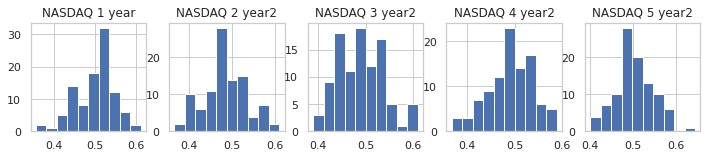

In [24]:
print_results("NASDAQ", na_1_arima_313, na_2_arima_313, na_3_arima_313, na_4_arima_313, na_5_arima_313)

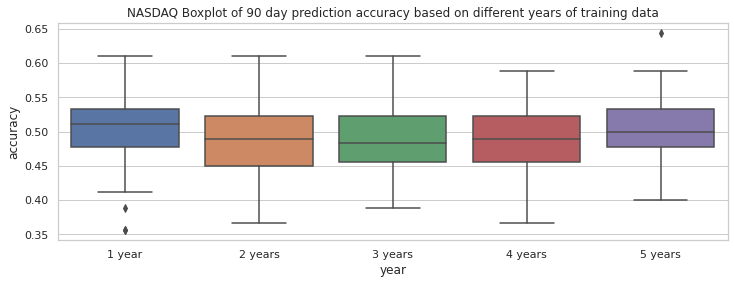

In [25]:
print_results_2("NASDAQ", na_1_arima_313, na_2_arima_313, na_3_arima_313, na_4_arima_313, na_5_arima_313)

In [26]:
# anova
print(stats.f_oneway(na_1_arima_313, na_1_arima_updated))
print(stats.f_oneway(na_2_arima_313, na_2_arima_updated))
print(stats.f_oneway(na_3_arima_313, na_3_arima_updated))
print(stats.f_oneway(na_4_arima_313, na_4_arima_updated))
print(stats.f_oneway(na_5_arima_313, na_5_arima_updated))

F_onewayResult(statistic=2.1362841800166295, pvalue=0.1454351828048392)
F_onewayResult(statistic=3.1959704729009744, pvalue=0.07535705697007163)
F_onewayResult(statistic=1.1938655409939376, pvalue=0.27587885637252885)
F_onewayResult(statistic=0.20249007274416306, pvalue=0.6532131590717771)
F_onewayResult(statistic=0.0676533697195282, pvalue=0.7950562697245482)


ARIMA 322

In [27]:
sp_1_arima_322 = helper_ari(1, df_sp, "2015-01-01", "2020-06-01", 3, 2, 2)
sp_2_arima_322 = helper_ari(2, df_sp, "2015-01-01", "2019-06-01", 3, 2, 2)
sp_3_arima_322 = helper_ari(3, df_sp, "2015-01-01", "2018-06-01", 3, 2, 2)
sp_4_arima_322 = helper_ari(4, df_sp, "2015-01-01", "2017-06-01", 3, 2, 2)
sp_5_arima_322 = helper_ari(5, df_sp, "2015-01-01", "2016-06-01", 3, 2, 2)

S&P 500 , 1 year:  0.5394444444444446  length:  100
S&P 500 , 2 year2:  0.5424444444444447  length:  100
S&P 500 , 3 year2:  0.5521111111111116  length:  100
S&P 500 , 4 year2:  0.569555555555556  length:  100
S&P 500 , 5 year2:  0.5691111111111116  length:  100
S&P 500  f value: 8.33193570680841  p-value:  1.6467630016891642e-06


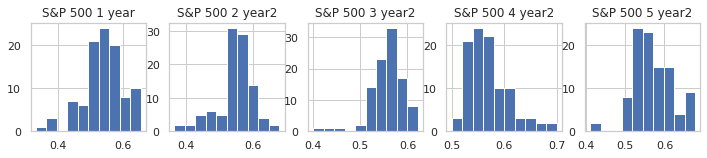

In [28]:
print_results("S&P 500", sp_1_arima_322, sp_2_arima_322, sp_3_arima_322, sp_4_arima_322, sp_5_arima_322)

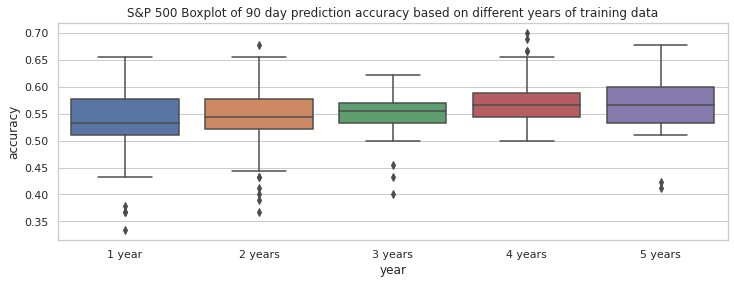

In [29]:
print_results_2("S&P 500", sp_1_arima_322, sp_2_arima_322, sp_3_arima_322, sp_4_arima_322, sp_5_arima_322)

In [30]:
print(stats.f_oneway(sp_1_arima_322, sp_1_arima_updated))
print(stats.f_oneway(sp_2_arima_322, sp_2_arima_updated))
print(stats.f_oneway(sp_3_arima_322, sp_3_arima_updated))
print(stats.f_oneway(sp_4_arima_322, sp_4_arima_updated))
print(stats.f_oneway(sp_5_arima_322, sp_5_arima_updated))

F_onewayResult(statistic=15.001762550441404, pvalue=0.0001459021831670028)
F_onewayResult(statistic=17.80761896314693, pvalue=3.7200545354976486e-05)
F_onewayResult(statistic=116.83652010874658, pvalue=1.0571462193750493e-21)
F_onewayResult(statistic=116.51213297956458, pvalue=1.171729477845059e-21)
F_onewayResult(statistic=66.31852834458275, pvalue=4.2292802361362624e-14)


In [31]:
na_1_arima_322 = helper_ari(1, df_na, "2015-01-01", "2020-06-01", 3, 2, 2)
na_2_arima_322 = helper_ari(2, df_na, "2015-01-01", "2019-06-01", 3, 2, 2)
na_3_arima_322 = helper_ari(3, df_na, "2015-01-01", "2018-06-01", 3, 2, 2)
na_4_arima_322 = helper_ari(4, df_na, "2015-01-01", "2017-06-01", 3, 2, 2)
na_5_arima_322 = helper_ari(5, df_na, "2015-01-01", "2016-06-01", 3, 2, 2)

NASDAQ , 1 year:  0.560111111111111  length:  100
NASDAQ , 2 year2:  0.571666666666667  length:  100
NASDAQ , 3 year2:  0.5498888888888892  length:  100
NASDAQ , 4 year2:  0.5713333333333337  length:  100
NASDAQ , 5 year2:  0.5872222222222225  length:  100
NASDAQ  f value: 4.862665645659315  p-value:  0.0007455447783810043


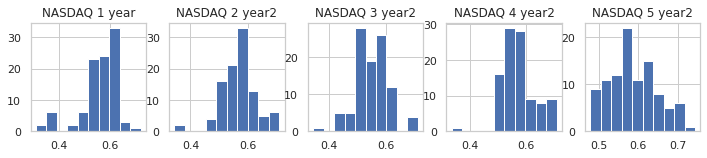

In [32]:
print_results("NASDAQ", na_1_arima_322, na_2_arima_322, na_3_arima_322, na_4_arima_322, na_5_arima_322)

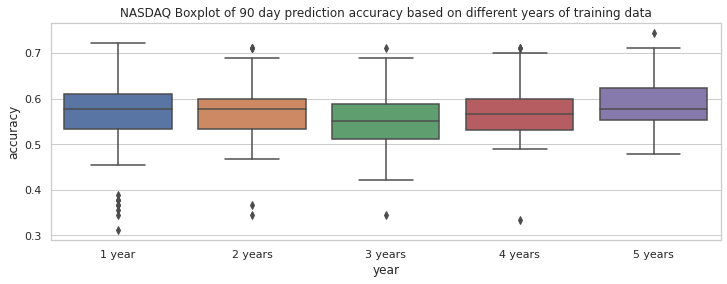

In [33]:
print_results_2("NASDAQ", na_1_arima_322, na_2_arima_322, na_3_arima_322, na_4_arima_322, na_5_arima_322)

In [34]:
print(stats.f_oneway(na_1_arima_322, na_1_arima_updated))
print(stats.f_oneway(na_2_arima_322, na_2_arima_updated))
print(stats.f_oneway(na_3_arima_322, na_3_arima_updated))
print(stats.f_oneway(na_4_arima_322, na_4_arima_updated))
print(stats.f_oneway(na_5_arima_322, na_5_arima_updated))

F_onewayResult(statistic=28.977159392805827, pvalue=2.0601020002409024e-07)
F_onewayResult(statistic=74.44794699327375, pvalue=2.0228388213834886e-15)
F_onewayResult(statistic=42.685610809554056, pvalue=5.313532203062428e-10)
F_onewayResult(statistic=119.00234632764516, pvalue=5.332608449947042e-22)
F_onewayResult(statistic=114.32244299239899, pvalue=2.353689114468512e-21)


## SARIMAX

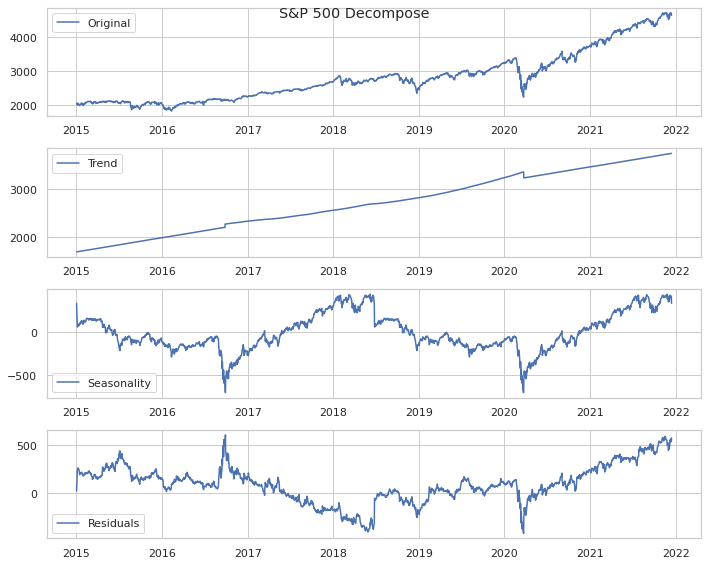

In [35]:
decomposition_sp = seasonal_decompose(x = df_sp, model='additive', extrapolate_trend='freq', period=int(len(df_sp)/2))


trend_sp = decomposition_sp.trend 
seasonal_sp = decomposition_sp.seasonal 
residual_sp = decomposition_sp.resid

plt.rcParams.update({'figure.figsize':(10,8)})
fig, ax = plt.subplots(nrows=4, ncols=1)
ax[0].plot(df_sp, label='Original') 
ax[0].legend(loc='best') 
ax[1].plot(trend_sp, label='Trend') 
ax[1].legend(loc='best')  
ax[2].plot(seasonal_sp,label='Seasonality') 
ax[2].legend(loc='best') 
ax[3].plot(residual_sp, label='Residuals') 
ax[3].legend(loc='best') 
plt.tight_layout()
plt.suptitle("S&P 500 Decompose")
plt.show()

df_sp_new = df_sp.copy()
df_sp_new['seasonal'] = seasonal_sp

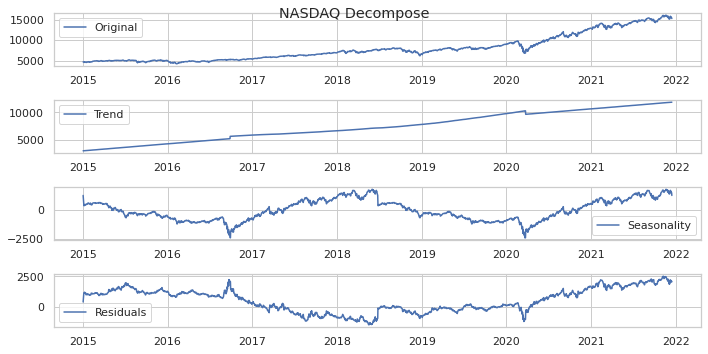

In [36]:
decomposition_na = seasonal_decompose(x = df_na, model='additive', extrapolate_trend='freq', period=int(len(df_na)/2))


trend_na = decomposition_na.trend 
seasonal_na = decomposition_na.seasonal 
residual_na = decomposition_na.resid

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots(nrows=4, ncols=1)
ax[0].plot(df_na, label='Original') 
ax[0].legend(loc='best') 
ax[1].plot(trend_na, label='Trend') 
ax[1].legend(loc='best') 
ax[2].plot(seasonal_na,label='Seasonality') 
ax[2].legend(loc='best') 
ax[3].plot(residual_na, label='Residuals') 
ax[3].legend(loc='best') 
plt.tight_layout()
plt.suptitle("NASDAQ Decompose") 
plt.show()

df_na_new = df_na.copy() # add seasonal data
df_na_new['seasonal'] = seasonal_na

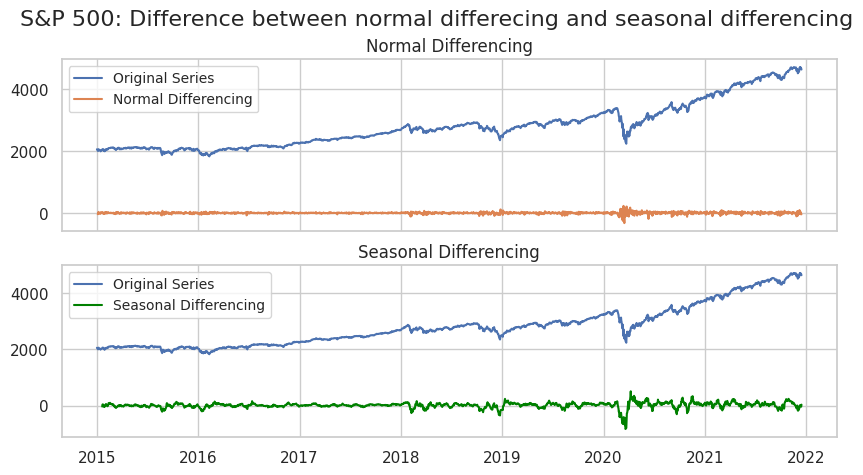

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual
axes[0].plot(df_sp, label='Original Series')
axes[0].plot(df_sp.diff(1), label='Normal Differencing')
axes[0].set_title('Normal Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal 
axes[1].plot(df_sp, label='Original Series')
axes[1].plot(df_sp.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('S&P 500: Difference between normal differecing and seasonal differencing', fontsize=16)
plt.show()

### Fit the model

In [38]:
sxmodel_sp = pm.auto_arima(df_sp_new[['close']], exogenous=df_sp_new[['seasonal']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel_sp.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=8.84 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=19747.940, Time=0.22 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=16546.050, Time=7.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=18403.022, Time=9.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=19835.177, Time=0.79 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=16930.108, Time=0.68 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=16330.276, Time=21.10 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=31.17 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.68 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=19715.358, Time=16.11 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=16294.851, Time=33.57 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=16514.531, Time=10.20 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=34.28 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=14.53 sec
 ARIMA(3,0,0)(2,1,0)[12] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1751
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -8120.486
Date:                            Tue, 14 Dec 2021   AIC                          16256.972
Time:                                    23:21:36   BIC                          16300.661
Sample:                                         0   HQIC                         16273.127
                                           - 1751                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6565      0.644      2.571      0.010       0.394       2.919
seasonal       0.8489      0.008    105.512      0.000       0.833       0.865
ar.L1          0.8302      0.016     51.827      0.000       0.799       0.862
ar.L2          0.2748      0.018     15.616      0.000       0.240       0.309
ar.L3         -0.1541      0.017     -9.225      0.000      -0.187      -0.121
ar.S.L12      -0.6412      0.016    -40.569      0.000      -0.672      -0.610
ar.S.L24      -0.3365      0.017    -19.523      0.000      -0.370      -0.303
sigma2       664.6382     11.783     56.409      0.000     641.545     687.732
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              3344.46
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
sxmodel_na = pm.auto_arima(df_na_new[['close']], exogenous=df_na_new[['seasonal']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel_na.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=13.18 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=24163.317, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=20890.799, Time=7.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=22777.188, Time=9.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=24285.876, Time=1.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=21296.605, Time=0.98 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=20687.612, Time=20.45 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=29.69 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=11.45 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=24128.183, Time=22.94 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=20666.927, Time=25.65 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=20875.696, Time=8.91 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=34.94 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=17.51 sec
 ARIMA(3,0,0)(2,1,0)[12] in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1751
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood              -10312.987
Date:                            Tue, 14 Dec 2021   AIC                          20641.975
Time:                                    23:28:42   BIC                          20685.663
Sample:                                         0   HQIC                         20658.130
                                           - 1751                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.1442      2.415      2.958      0.003       2.411      11.878
seasonal       0.8583      0.010     89.881      0.000       0.840       0.877
ar.L1          0.8497      0.019     44.226      0.000       0.812       0.887
ar.L2          0.2223      0.022     10.325      0.000       0.180       0.264
ar.L3         -0.1258      0.018     -7.144      0.000      -0.160      -0.091
ar.S.L12      -0.6421      0.017    -37.350      0.000      -0.676      -0.608
ar.S.L24      -0.3264      0.018    -17.806      0.000      -0.362      -0.290
sigma2      8236.8356    163.571     50.356      0.000    7916.243    8557.429
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1678.09
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training

In [40]:
def helper_sri (n, dataset, startstring, endstring):
  accuracy_list = []

  startdate = datetime.strptime(startstring, '%Y-%m-%d')
  enddate = datetime.strptime(endstring, '%Y-%m-%d')
  r = (enddate + relativedelta(days=1)-startdate).days
  datelist = [(startdate+relativedelta(days=i)).strftime('%Y-%m-%d') for i in range(r)]

  datelist = random.sample(datelist, 50) # get 50 samples cuz each fit takes too long

  for item in datelist:
    today = datetime.strptime(item, '%Y-%m-%d')
    future_date = today + relativedelta(years = n)
    future_date_after = future_date + relativedelta(days = 1)
    future_date = future_date.strftime('%Y-%m-%d')
    future_date_after = future_date_after.strftime('%Y-%m-%d')

    
    train = dataset[['close']][today:future_date]
    test = dataset[['close']][future_date_after:].head(90)
    test_seasonal = dataset[['seasonal']][future_date_after:].head(90)

    try:
      smodel = sm.tsa.statespace.SARIMAX(train,
                                order=(3,0,0),
                                seasonal_order=(2,1,0, 12),
                                exog = df_na_new[['seasonal']][today:future_date],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

      results = smodel.fit()
    except:
      continue

    # Forecast
    future_forecast = results.forecast(90, exog = test_seasonal)
    # This returns an array of predictions
    fc_series = pd.DataFrame(future_forecast)
    fc_series.index = test.index
    fc_series.columns = ['close']

    test_trend = [0]
    temp = list(test.close)

    for i in range(1, len(test)) :
      if temp[i] >= temp[i-1] :
        test_trend.append(1)
      else:
        test_trend.append(-1)


    # now we deal with the begining element
    if temp[0] >= list(train.close)[-1] :
      test_trend[0] = 1
    else:
      test_trend[0] = -1


    #now forcast
    forecast_trend = [0]
    temp = list(fc_series["close"])

    for i in range(1, len(test)) :
      if temp[i] >= temp[i-1] :
        forecast_trend.append(1)
      else:
        forecast_trend.append(-1)

    # now we deal with the begining element
    if temp[0] >= list(train.close)[-1] :
      forecast_trend[0] = 1
    else:
      forecast_trend[0] = -1


    result = test
    result["test_trend"] = test_trend
    result["forecast"] = fc_series["close"]
    result["forecast_trend"] = forecast_trend
    accuracy = sum(result.test_trend == result.forecast_trend) / len(test)
    accuracy_list.append(accuracy)

  return accuracy_list

In [41]:
sp_1_sarimax = helper_sri(1, df_sp_new, "2015-01-01", "2020-06-01")

In [42]:
sp_2_sarimax = helper_sri(2,  df_sp_new, "2015-01-01", "2019-06-01")

In [43]:
sp_3_sarimax = helper_sri(3, df_sp_new, "2015-01-01", "2018-06-01")

In [44]:
sp_4_sarimax = helper_sri(4, df_sp_new, "2015-01-01", "2017-06-01")

In [45]:
sp_5_sarimax = helper_sri(5, df_sp_new, "2015-01-01", "2016-06-01")

S&P 500 , 1 year:  0.583777777777778  length:  50
S&P 500 , 2 year2:  0.5797777777777777  length:  50
S&P 500 , 3 year2:  0.5606666666666668  length:  50
S&P 500 , 4 year2:  0.5695555555555557  length:  50
S&P 500 , 5 year2:  0.5771111111111111  length:  50
S&P 500  f value: 0.6413863254097595  p-value:  0.6334637738957536


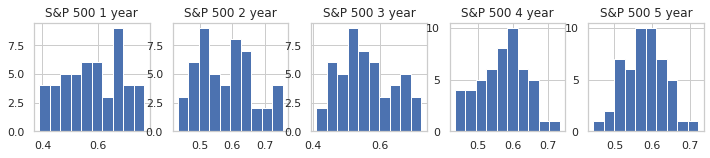

In [57]:
print_results("S&P 500", sp_1_sarimax, sp_2_sarimax, sp_3_sarimax, sp_4_sarimax, sp_5_sarimax)

In [47]:
na_1_sarimax = helper_sri(1, df_na_new, "2015-01-01", "2020-06-01")

In [48]:
na_2_sarimax = helper_sri(2,  df_na_new, "2015-01-01", "2019-06-01")

In [49]:
na_3_sarimax = helper_sri(3, df_na_new, "2015-01-01", "2018-06-01")

In [50]:
na_4_sarimax = helper_sri(4, df_na_new, "2015-01-01", "2017-06-01")

In [51]:
na_5_sarimax = helper_sri(5, df_na_new, "2015-01-01", "2016-06-01")

NASDAQ , 1 year:  0.6655555555555559  length:  50
NASDAQ , 2 year2:  0.668222222222222  length:  50
NASDAQ , 3 year2:  0.6853333333333331  length:  50
NASDAQ , 4 year2:  0.6984444444444443  length:  50
NASDAQ , 5 year2:  0.7262222222222222  length:  50
NASDAQ  f value: 1.9948408953087018  p-value:  0.09591808128625391


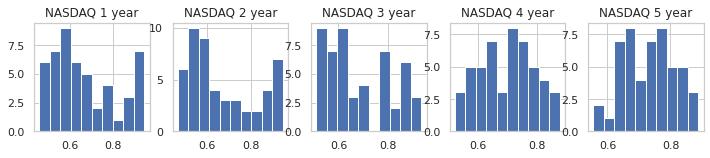

In [58]:
print_results("NASDAQ", na_1_sarimax, na_2_sarimax, na_3_sarimax, na_4_sarimax, na_5_sarimax)